In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from math import radians, cos, sin, asin, sqrt, ceil
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

In [2]:
# load in data sets
events = pd.read_csv('events_1_1.csv')
iata = pd.read_csv('iata_1_1.csv')

# Inspect and clean data

In [3]:
events.head()

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
0,2017-04-27 11:06:51,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
1,2017-04-27 20:15:27,book,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1
2,2017-04-27 23:03:43,book,f953f0,2017-10-08,2017-10-11,BER,CGN,2,0
3,2017-04-27 15:17:50,book,794d35,2017-04-28,2017-05-01,BER,BCN,1,0
4,2017-04-27 22:51:57,book,ca4f94,2017-05-16,2017-05-22,DEL,BKK,4,0


In [4]:
# expect the shape of the df
events.shape

(47007, 9)

In [5]:
# ensure we don't have duplicates
len(events.drop_duplicates())

45898

In [6]:
# drop duplicates
events = events.drop_duplicates()

In [7]:
# check for nulls
events.isna().sum()

ts               0
event_type       0
user_id          0
date_from       22
date_to          3
origin           0
destination      0
num_adults       0
num_children     0
dtype: int64

In [8]:
# let's get rid of those few rows which are null
events = events.dropna()

In [9]:
# inspect data types
events.dtypes

ts              object
event_type      object
user_id         object
date_from       object
date_to         object
origin          object
destination     object
num_adults       int64
num_children     int64
dtype: object

In [10]:
# convert timestamps and dates to datetime objects
events['ts'] = pd.to_datetime(events['ts'])
events['date_from'] = pd.to_datetime(events['date_from'])
events['date_to'] = pd.to_datetime(events['date_to'])

In [11]:
events.dtypes

ts              datetime64[ns]
event_type              object
user_id                 object
date_from       datetime64[ns]
date_to         datetime64[ns]
origin                  object
destination             object
num_adults               int64
num_children             int64
dtype: object

In [12]:
# inspect the iata data set
iata.head()

,iata_code,lat,lon
0,LON,51.50,-0.17
1,MOW,55.75,37.70
2,NYC,40.71,-74.01
3,PAR,48.85,2.35
4,IST,41.01,28.95


In [13]:
# check length of df
len(iata)

500

In [14]:
# ensure there are no duplicates
iata['iata_code'].nunique()

298

Of the 500 rows in the IATA data set, we see that there are only 298 unique values. These duplicates will need to be removed before this dataframe is merged to the events dataframe.

In [15]:
# let's see how wildly these are varying on average
iata.groupby('iata_code').diff().dropna().describe()

,lat,lon
count,202.000000,202.000000
mean,0.007327,0.014950
std,0.108810,0.125814
min,-0.390000,-0.400000
25%,-0.050000,-0.060000
50%,0.000000,0.015000
75%,0.067500,0.090000
max,0.460000,0.350000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe23f8ba670>,
      dtype=object)

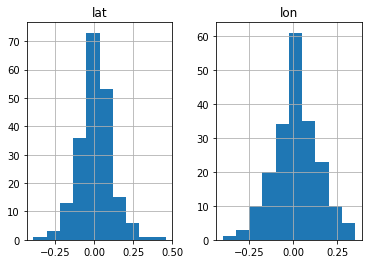

In [16]:
iata.groupby('iata_code').diff().dropna().hist()

We can see that for all duplicate records, most of them have lat/longs that are close to the original. For this reason, I will take the means of the duplicates to give us a central point.

In [17]:
# remove duplicates by taking means of duplicates
iata = iata.groupby('iata_code').mean().reset_index()

In [18]:
len(iata)

298

In [19]:
iata['iata_code'].unique()

array(['ABV', 'ADB', 'ADD', 'ADL', 'AEP', 'AER', 'AGP', 'AKL', 'ALA',
       'ALC', 'ALG', 'AMS', 'ANC', 'ANK', 'ARN', 'ATH', 'ATL', 'AUH',
       'AUS', 'AYT', 'BAH', 'BCN', 'BER', 'BET', 'BGY', 'BHX', 'BHZ',
       'BJS', 'BKK', 'BLR', 'BNA', 'BNE', 'BOG', 'BOM', 'BOS', 'BPN',
       'BRU', 'BSB', 'BUD', 'BUE', 'BUH', 'BWI', 'BZE', 'CAI', 'CAN',
       'CAS', 'CCS', 'CCU', 'CDG', 'CEB', 'CGH', 'CGK', 'CGN', 'CGO',
       'CHC', 'CHI', 'CJU', 'CKG', 'CLT', 'CMB', 'CMN', 'CNF', 'CNS',
       'CPH', 'CPT', 'CSX', 'CTS', 'CTU', 'CUN', 'DAC', 'DAL', 'DAR',
       'DCA', 'DEL', 'DEN', 'DFW', 'DLC', 'DME', 'DMK', 'DMM', 'DOH',
       'DPS', 'DTT', 'DTW', 'DUB', 'DUR', 'DUS', 'DXB', 'EDI', 'ESB',
       'EWR', 'EZE', 'FAI', 'FCO', 'FLL', 'FRA', 'FTW', 'FUK', 'GDL',
       'GEA', 'GIG', 'GLA', 'GMP', 'GRU', 'GVA', 'HAK', 'HAM', 'HAN',
       'HAV', 'HEL', 'HET', 'HGH', 'HIR', 'HKG', 'HKT', 'HND', 'HNL',
       'HOU', 'HRB', 'HYD', 'IAD', 'IAH', 'ICN', 'IEV', 'IST', 'ITM',
       'IZM', 'JED',

There are some "airports" in this list that aren't airports at all, such as BER, PAR, NYC. However, knowing the nature of this data, these may represent "all airports in an area," so I will leave them here.

In [20]:
# merge IATA code dataframe twice; once for origin, once for destination

events = events.merge(iata, left_on='origin', right_on='iata_code')
events = events.rename(columns = {'lat':'origin_lat', 'lon':'origin_lon'})
events.drop(columns='iata_code', inplace=True)

events = events.merge(iata, left_on='destination', right_on='iata_code')
events = events.rename(columns = {'lat':'dest_lat', 'lon':'dest_lon'})
events.drop(columns='iata_code', inplace=True)

In [21]:
# sort values for easier interpretation
events.sort_values(by=['user_id', 'ts'], inplace=True)

In [22]:
events.head()

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,origin_lat,origin_lon,dest_lat,dest_lon
15155,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,50.08,8.620,36.725,3.125
35012,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,48.85,2.350,-12.940,-38.420
1981,2017-04-24 21:25:10,search,0002e3,2017-05-01,2017-05-01,PAR,ATH,1,0,48.85,2.350,37.960,23.830
10897,2017-04-27 16:34:02,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,43.68,7.245,32.045,34.835
10896,2017-04-27 16:35:35,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,43.68,7.245,32.045,34.835


Before adding any features, I will explore the data we have to undertstand it a bit better. A few questions I would like to answer before proceeding:
1. What is the balance of classes in our data?
2. What do the distributions of the continuous features look like?
3. What does the distribution of visits per user look like?
4. How many unique users exist in this data set?
5. What is the timeframe of this data set?

In [23]:
# as we will be predicting the likelihood of a user to book, let's quickly investigate our class balance
events['event_type'].value_counts()/len(events)

search    0.960611
book      0.039389
Name: event_type, dtype: float64

We have a very imbalanced data set with only 3.9% of records representing the positive class (booking). I'll address this at a later point when building the model.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe23f828b50>,
      dtype=object)

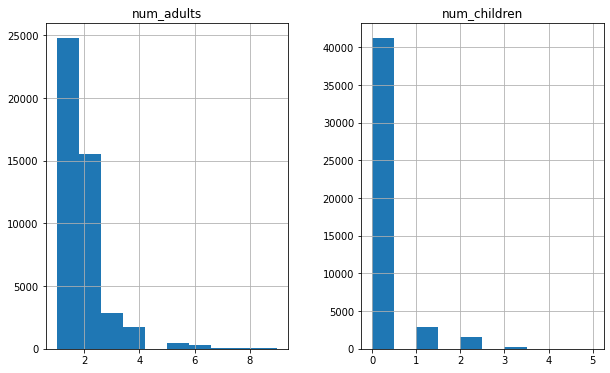

In [24]:
# distribution of continuous features
events[['num_adults', 'num_children']].hist(figsize=(10,6))

We can see that the majority of our data contains records for searches with 1-2 adults and 0 children.

In [25]:
events.groupby('user_id')['ts'].count().describe()

count    31165.000000
mean         1.472036
std          1.115935
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         24.000000
Name: ts, dtype: float64

Most user_ids only have one event, but very few have as many as 24 events associated with them. We have 31165 unique users in this data set.

In [26]:
events['ts'].describe()

count                   45876
unique                  43109
top       2017-04-29 18:08:03
freq                        4
first     2017-04-18 04:41:09
last      2017-05-02 04:06:34
Name: ts, dtype: object

The timeframe of this data is 2017-04-18 to 2017-05-02.

In [27]:
events.describe()

,num_adults,num_children,origin_lat,origin_lon,dest_lat,dest_lon
count,45876.000000,45876.000000,45876.000000,45876.000000,45876.000000,45876.000000
mean,1.675931,0.146133,47.942455,8.343125,37.768583,9.900193
std,0.987431,0.477010,8.590077,21.079646,17.651020,51.943529
min,1.000000,0.000000,-43.510000,-157.925000,-43.510000,-157.925000
25%,1.000000,0.000000,48.245000,4.415000,36.695000,-3.285000
50%,1.000000,0.000000,48.850000,8.620000,41.010000,7.245000
75%,2.000000,0.000000,51.250000,10.005000,48.850000,27.140000
max,9.000000,5.000000,64.130000,177.430000,64.825000,177.430000


# Feature Engineering

This section will focus on feature engineering from our original data set. I will extract features from the columns that we have available, as well as features related to the history of the customer.

### Features extracted from existing columns

In [28]:
# extract day of week from the event timestamp. As DOW is a cyclical feature, I will add sin and cosine to represent this.
events['ts_dow'] = events['ts'].dt.dayofweek + 1
events['ts_sin'] = np.sin(2 * np.pi * events['ts_dow']/7)
events['ts_cos'] = np.cos(2 * np.pi * events['ts_dow']/7)

In [29]:
# do the same with the from date
events['from_dow'] = events['date_from'].dt.dayofweek + 1
events['from_sin'] = np.sin(2 * np.pi * events['from_dow']/7)
events['from_cos'] = np.cos(2 * np.pi * events['from_dow']/7)

In [30]:
# as well as the to date
events['to_dow'] = events['date_to'].dt.dayofweek + 1
events['to_sin'] = np.sin(2 * np.pi * events['to_dow']/7)
events['to_cos'] = np.cos(2 * np.pi * events['to_dow']/7)

In [31]:
# number of days to arrival (between event timestamp and from date)
events['days_to_arrival'] = (events['date_from'] - events['ts']).apply(lambda l: int(l/pd.Timedelta('1 hour')/24))

In [32]:
# length of holiday (date_to - date_from)
events['length_of_stay'] = (events['date_to'] - events['date_from']).apply(lambda l: l.days)

In [33]:
# haversine formula to calculate distance between origin and destination
def haversine(lat1, lon1, lat2, lon2):
    """
    Determines the great-circle distance between two points 
    on a sphere given their longitudes and latitudes.
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # radius of earth in km
    return round(c * r)

In [34]:
# add haversine distance between origin and destination

events['distance'] = events.apply(lambda row: haversine(row['origin_lat'],
                                                        row['origin_lon'],
                                                        row['dest_lat'],
                                                        row['dest_lon']),
                                  axis=1)

In [35]:
# spot check the haversine formula vs online calculator to ensure accuracy
events[['origin_lat', 'origin_lon', 'dest_lat', 'dest_lon', 'distance']].head()

,origin_lat,origin_lon,dest_lat,dest_lon,distance
15155,50.08,8.620,36.725,3.125,1549
35012,48.85,2.350,-12.940,-38.420,7952
1981,48.85,2.350,37.960,23.830,2104
10897,43.68,7.245,32.045,34.835,2728
10896,43.68,7.245,32.045,34.835,2728


In [36]:
# drop "helper" columns
events.drop(columns=['ts_dow', 'from_dow', 'to_dow'], inplace=True)

In [37]:
events.head()

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,origin_lat,...,dest_lon,ts_sin,ts_cos,from_sin,from_cos,to_sin,to_cos,days_to_arrival,length_of_stay,distance
15155,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,50.08,...,3.125,-0.781831,0.623490,0.433884,-0.900969,-0.974928,-0.222521,10,16,1549
35012,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,48.85,...,-38.420,-0.974928,-0.222521,-0.974928,-0.222521,-0.974928,-0.222521,139,28,7952
1981,2017-04-24 21:25:10,search,0002e3,2017-05-01,2017-05-01,PAR,ATH,1,0,48.85,...,23.830,0.781831,0.623490,0.781831,0.623490,0.781831,0.623490,6,0,2104
10897,2017-04-27 16:34:02,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,43.68,...,34.835,-0.433884,-0.900969,-0.433884,-0.900969,-0.974928,-0.222521,41,29,2728
10896,2017-04-27 16:35:35,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,43.68,...,34.835,-0.433884,-0.900969,-0.433884,-0.900969,-0.974928,-0.222521,41,29,2728


### Features based on user's history

In [38]:
# this represents the number of times that customer has visited
events['num_visits'] = events.groupby("user_id")["ts"].rank("dense")

In [39]:
# hours since last event
events['hours_since_last_event'] = (events.groupby('user_id')['ts'].diff().dt.total_seconds()/3600)

In [40]:
# test if origin/destination changed between events
events['last_origin'] = events.groupby('user_id')['origin'].shift()
events['origin_changed'] = np.where((events['origin'] != events['last_origin']) & ( ~events['last_origin'].isna()), 1, 0)

events['last_dest'] = events.groupby('user_id')['destination'].shift()
events['dest_changed'] = np.where((events['destination'] != events['last_dest']) & ( ~events['last_dest'].isna()), 1, 0)

In [41]:
# test if dates changed
events['last_date_from'] = events.groupby('user_id')['date_from'].shift()
events['date_from_changed'] = np.where((events['date_from'] != events['last_date_from']) & ( ~events['last_date_from'].isna()), 1, 0)

events['last_date_to'] = events.groupby('user_id')['date_to'].shift()
events['date_to_changed'] = np.where((events['date_to'] != events['last_date_to']) & ( ~events['last_date_to'].isna()), 1, 0)

In [42]:
# get diffs for num_adults and num_children
events['num_adults_changed'] = events.groupby('user_id')['num_adults'].diff()
events['num_children_changed'] = events.groupby('user_id')['num_children'].diff()

In [43]:
# convert these to binaries to indicate if they changed between events
events.loc[(events['num_adults_changed'] != 0) & (events['num_adults_changed'].notna()), ['num_adults_changed']] = 1
events.loc[(events['num_children_changed'] != 0) & (events['num_children_changed'].notna()), ['num_children_changed']] = 1

In [44]:
# once again remove the helper columns
events.drop(columns=['last_origin', 'last_dest', 'last_date_from', 'last_date_to'], inplace=True)

Now that we have several new features, let's understand their distributions and check for outliers.

In [45]:
events.columns

Index(['ts', 'event_type', 'user_id', 'date_from', 'date_to', 'origin',
       'destination', 'num_adults', 'num_children', 'origin_lat', 'origin_lon',
       'dest_lat', 'dest_lon', 'ts_sin', 'ts_cos', 'from_sin', 'from_cos',
       'to_sin', 'to_cos', 'days_to_arrival', 'length_of_stay', 'distance',
       'num_visits', 'hours_since_last_event', 'origin_changed',
       'dest_changed', 'date_from_changed', 'date_to_changed',
       'num_adults_changed', 'num_children_changed'],
      dtype='object')

In [46]:
# look at continuous features first (excluding the original once which were already inspected)
continuous = ['days_to_arrival', 'length_of_stay', 'distance', 'num_visits', 'hours_since_last_event']
events[continuous].describe()

,days_to_arrival,length_of_stay,distance,num_visits,hours_since_last_event
count,45876.000000,45876.000000,45876.000000,45876.000000,14711.000000
mean,76.642013,9.307546,3235.466889,1.638024,7.434882
std,74.849258,15.094192,3551.107756,1.269753,26.714603
min,-1.000000,0.000000,9.000000,1.000000,0.000000
25%,17.000000,2.000000,836.000000,1.000000,0.023333
50%,51.000000,5.000000,1574.000000,1.000000,0.100000
75%,125.000000,12.000000,5250.000000,2.000000,0.460139
max,362.000000,331.000000,19433.000000,23.000000,295.940278


A few observations from the above data:
- Some observations have days_to_arrival < 0, which cannot be true.
- Some observations have length_of_stay as high as 331 - potentially true, but these outliers could impact the classifer.
- Some observations have distance as low as 9km - that must be a short flight!
- The minimum hours_since_last_event is 0; does this mean we have duplicate events for some users?

In [47]:
# inspect the rows with negative days_to_arrival
events[events['days_to_arrival'] < 0]

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,origin_lat,...,length_of_stay,distance,num_visits,hours_since_last_event,origin_changed,dest_changed,date_from_changed,date_to_changed,num_adults_changed,num_children_changed
15094,2017-04-24 02:15:13,search,9bf922,2017-04-23,2017-05-02,PAR,ALG,1,0,48.85,...,9,1350,1.0,NaN,0,0,0,0,NaN,NaN
22004,2017-04-29 01:05:05,search,c1b343,2017-04-28,2017-04-28,NYC,HOU,1,0,40.71,...,0,2281,1.0,NaN,0,0,0,0,NaN,NaN
28515,2017-04-28 01:24:03,search,f739e9,2017-04-27,2017-05-18,HNL,SIN,1,0,21.32,...,21,10798,1.0,NaN,0,0,0,0,NaN,NaN
7987,2017-04-25 00:17:57,search,fde07c,2017-04-24,2017-05-01,PAR,LIS,1,0,48.85,...,7,1450,1.0,NaN,0,0,0,0,NaN,NaN


In [48]:
# remove the few rows where days_to_arrival is negative
events = events[events['days_to_arrival'] >= 0]

In [49]:
# let's look at the percentiles of length_of_stay in more detail
events['length_of_stay'].quantile([0.9, 0.95, 0.99, 0.999, 0.9999])

0.9000     21.0000
0.9500     29.0000
0.9900     67.0000
0.9990    182.0000
0.9999    273.8258
Name: length_of_stay, dtype: float64

In [50]:
# 99% of our observations have length_of_stay <= 67 days. exclude the outliers.
events = events[events['length_of_stay'] <= 67]

In [51]:
# look at distance closer
events['distance'].quantile([.0001, .001, .01, .05])

0.0001     13.0
0.0010     42.0
0.0100    329.0
0.0500    470.0
Name: distance, dtype: float64

In [52]:
events[events['distance'] <= 42][['origin', 'destination']].drop_duplicates()

,origin,destination
45768,BER,SXF
39487,PAR,CDG
41030,DUS,CGN
44618,CDG,PAR
15693,PAR,ORY
43802,SHA,PVG
45806,TXL,SXF
27865,CGN,DUS
17249,SXF,BER
44223,ORY,PAR


In [53]:
# how many rows exist with this condition? how many of them were booked?
events[events['distance'] <= 42]['event_type'].value_counts()

search    53
book       4
Name: event_type, dtype: int64

It appears that the cases which have very short distances are generally related to the pseudo-IATA codes that I found above. For example, a flight from BER to SXF isn't possible since BER isn't an airport (not yet at least, we're still waiting). There are also cases such as DUS to CGN, which are real airports, but people lilely aren't flying 40km to get there. As these outliers only represent 53 rows and 4 of which are bookings, I will exclude these.

In [54]:
events = events[events['distance'] > 42]

In [55]:
# look at cases where the event timestamps are duplicates
events[events['hours_since_last_event'] == 0]

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,origin_lat,...,length_of_stay,distance,num_visits,hours_since_last_event,origin_changed,dest_changed,date_from_changed,date_to_changed,num_adults_changed,num_children_changed
20547,2017-04-28 00:40:18,search,00f8fb,2017-04-28,2017-04-29,BER,FRA,1,0,52.520,...,1,429,1.0,0.0,0,0,0,1,0.0,0.0
27165,2017-04-29 17:16:43,search,015c9e,2017-07-07,2017-07-07,MUC,PMI,1,0,48.245,...,0,1203,1.0,0.0,0,0,1,1,0.0,0.0
20993,2017-05-02 00:54:55,search,01a4b3,2017-06-22,2017-06-25,AYT,FRA,1,0,36.905,...,3,2294,1.0,0.0,0,0,1,1,0.0,0.0
8325,2017-04-23 16:03:42,search,01ef2a,2017-10-28,2017-11-01,HAM,LIS,2,0,53.605,...,4,2199,1.0,0.0,0,0,1,1,0.0,0.0
14849,2017-04-28 13:27:59,search,024222,2017-08-21,2017-08-25,MRS,MAD,1,0,43.370,...,4,806,1.0,0.0,0,0,1,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21162,2017-04-26 14:39:02,search,ff04b2,2017-10-18,2017-11-05,PAR,LAX,1,0,48.850,...,18,9095,3.0,0.0,0,0,0,1,0.0,0.0
43145,2017-04-27 19:23:43,search,ff462e,2017-05-01,2017-05-01,SAW,STR,1,0,40.900,...,0,1803,2.0,0.0,1,1,1,1,0.0,0.0
45662,2017-04-27 20:30:06,search,ffb791,2017-08-22,2017-09-14,HAM,CGK,1,0,53.605,...,23,10995,1.0,0.0,0,0,0,1,0.0,0.0
39968,2017-04-29 12:12:49,search,ffcc37,2017-08-02,2017-08-05,CGN,MXP,2,0,50.905,...,3,600,2.0,0.0,0,0,1,1,0.0,0.0


In [56]:
# look at a few specific users in more detail
events[events['user_id'] == 'ffcc37']

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,origin_lat,...,length_of_stay,distance,num_visits,hours_since_last_event,origin_changed,dest_changed,date_from_changed,date_to_changed,num_adults_changed,num_children_changed
39965,2017-04-29 12:12:48,search,ffcc37,2017-08-09,2017-08-12,CGN,MXP,2,0,50.905,...,3,600,1.0,NaN,0,0,0,0,NaN,NaN
39966,2017-04-29 12:12:49,search,ffcc37,2017-08-09,2017-08-12,CGN,MXP,2,0,50.905,...,3,600,2.0,0.000278,0,0,0,0,0.0,0.0
39968,2017-04-29 12:12:49,search,ffcc37,2017-08-02,2017-08-05,CGN,MXP,2,0,50.905,...,3,600,2.0,0.000000,0,0,1,1,0.0,0.0


It appears that in cases where there are duplicates, the date_to seems to be the only column changing, based on a sample tested above. This could be an upstream data issue. Given the fact that this only affects 577 rows, it may be best to drop these. Before doing that, let's ensure that we're not losing many rows related to booking events.

In [57]:
events[events['hours_since_last_event'] == 0]['event_type'].value_counts()

search    577
Name: event_type, dtype: int64

In [58]:
events = events[events['hours_since_last_event'] != 0]

In [59]:
# check length of df after excluding the problematic rows
len(events)

44783

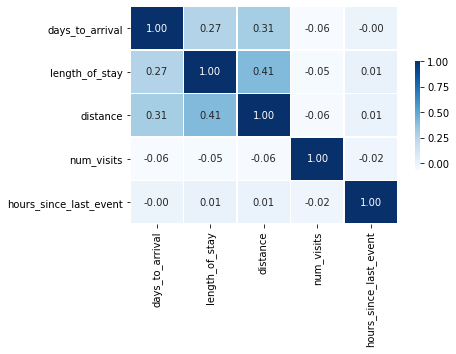

In [60]:
# have a quick look at the correlations of these continuous features
plt.figure()
sns.heatmap(events[continuous].corr(),  cmap='Blues', annot=True,
            fmt=".2f", square=False, linewidths=.5, cbar_kws={"shrink": .5})

In [61]:
# look at binary columns (after excluding rows without history)

events.dropna()[['origin_changed',
       'dest_changed', 'date_from_changed', 'date_to_changed',
       'num_adults_changed', 'num_children_changed']].describe()

,origin_changed,dest_changed,date_from_changed,date_to_changed,num_adults_changed,num_children_changed
count,13975.000000,13975.000000,13975.00000,13975.000000,13975.000000,13975.000000
mean,0.112701,0.119428,0.23127,0.240501,0.073488,0.017174
std,0.316239,0.324303,0.42166,0.427403,0.260946,0.129922
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


We can see that of all rows which follow another event:
- 11% changed the origin from the past event
- 11% changed the destination from the past event
- 23% changed the from date
- 24% changed the to date
- 7% changed the number of adults
- 2% changed the number of children

Next, we will have a look at a few distributions by event type to see how the behaviors differ between these groups.

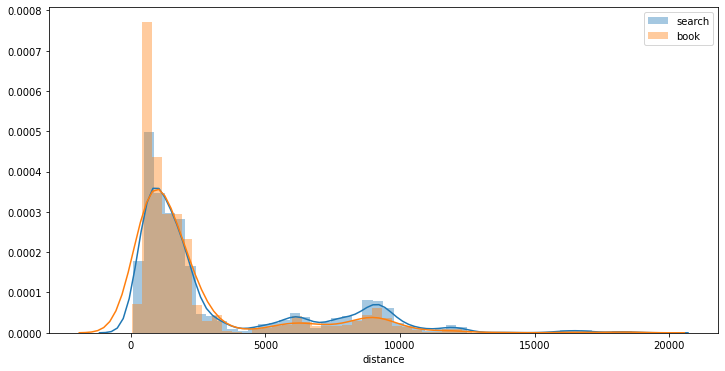

In [62]:
# distance by event_type

plt.figure(figsize = (12,6))

for i in events['event_type'].unique():
    sns.distplot(events['distance'][events['event_type'] == i], label=i)

    plt.legend(loc='best')

In [63]:
events.groupby('event_type')['distance'].describe()

,count,mean,std,min,25%,50%,75%,max
event_type,,,,,,,,
book,1788.0,2394.703579,2923.878766,48.0,690.0,1216.5,2110.0,18597.0
search,42995.0,3243.513455,3548.073238,97.0,842.0,1580.0,5250.0,19433.0


It looks like the average distance is lower for the booked group.

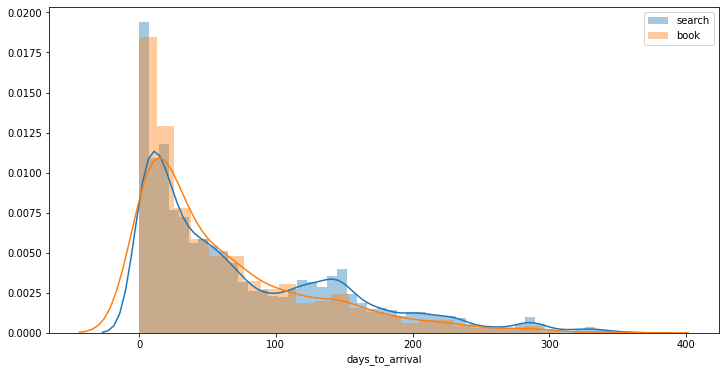

In [64]:
# days_to_arrival by event_type

plt.figure(figsize = (12,6))

for i in events['event_type'].unique():
    sns.distplot(events['days_to_arrival'][events['event_type'] == i], label=i)

    plt.legend(loc='best')

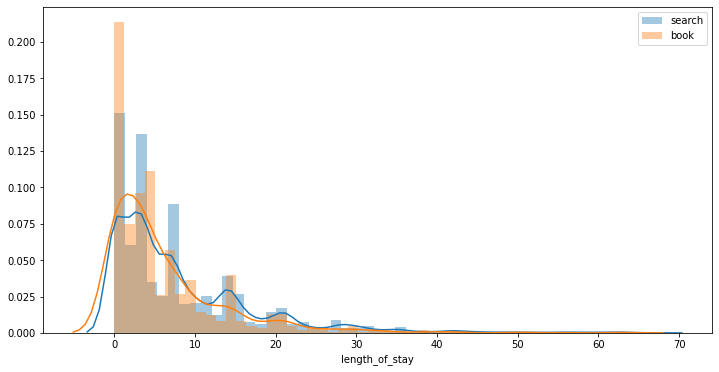

In [65]:
# length_of_stay by event type

plt.figure(figsize = (12,6))

for i in events['event_type'].unique():
    sns.distplot(events['length_of_stay'][events['event_type'] == i], label=i)

    plt.legend(loc='best')

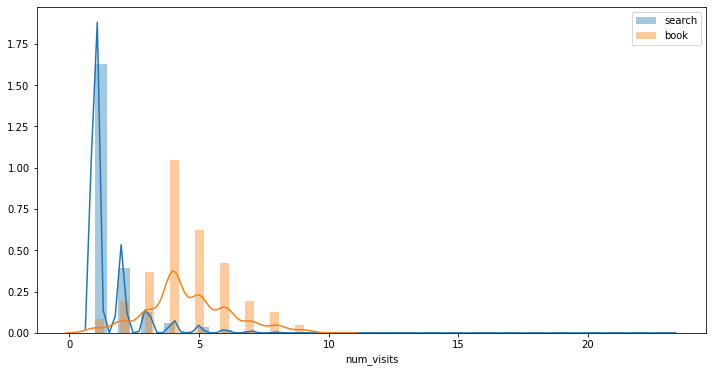

In [66]:
# num_visits by event type

plt.figure(figsize = (12,6))

for i in events['event_type'].unique():
    sns.distplot(events['num_visits'][events['event_type'] == i], label=i)

    plt.legend(loc='best')

In [67]:
events.groupby('event_type')['num_visits'].describe()

,count,mean,std,min,25%,50%,75%,max
event_type,,,,,,,,
book,1788.0,4.582215,1.631207,1.0,4.0,4.0,6.0,10.0
search,42995.0,1.511036,1.087397,1.0,1.0,1.0,2.0,23.0


Now this is interesting! We can see from above that the distributions of num_visits between groups is different. I have a feeling this feature could help out the model.

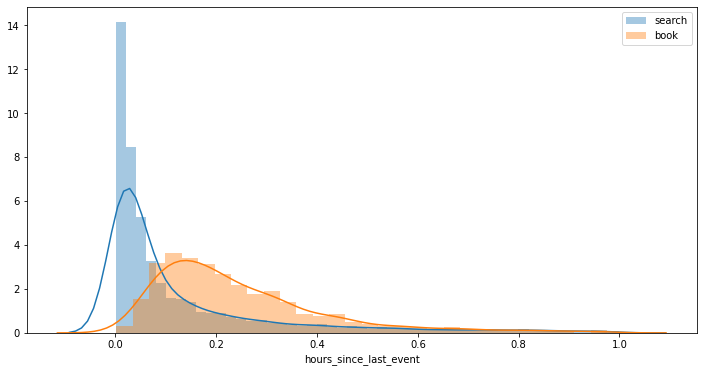

In [68]:
# hours_since_last_event by event type- for visualization purposes, a subset is shown below

plt.figure(figsize = (12,6))

for i in events['event_type'].unique():
    sns.distplot(events[events['hours_since_last_event'] <=1]['hours_since_last_event'][events['event_type'] == i], label=i)

    plt.legend(loc='best')

In [69]:
events.groupby('event_type')['hours_since_last_event'].describe()

,count,mean,std,min,25%,50%,75%,max
event_type,,,,,,,,
book,1740.0,2.307969,14.650951,0.001944,0.129167,0.212778,0.352500,286.338611
search,12235.0,8.482370,28.400013,0.000278,0.023333,0.085833,0.585833,295.940278


It looks like the average customer who books performs searches less frequently. This may also be useful in the model.

Finally, let's encode our target.

In [70]:
# thhis will be a binary column, with 1 representing booking event
events['target'] = events['event_type'].apply(lambda x: 1 if x =='book' else 0)

# Building the classifier

Now that we have a comprehensive set of features, I will build a binary classifier to predict the conversion event. Since this data set contains many rows with nulls (those without any history), I will use the XGBoost binary classifier, as it plays well with nulls. 

In [90]:
events.columns

Index(['ts', 'event_type', 'user_id', 'date_from', 'date_to', 'origin',
       'destination', 'num_adults', 'num_children', 'origin_lat', 'origin_lon',
       'dest_lat', 'dest_lon', 'ts_sin', 'ts_cos', 'from_sin', 'from_cos',
       'to_sin', 'to_cos', 'days_to_arrival', 'length_of_stay', 'distance',
       'num_visits', 'hours_since_last_event', 'origin_changed',
       'dest_changed', 'date_from_changed', 'date_to_changed',
       'num_adults_changed', 'num_children_changed', 'target'],
      dtype='object')

In [194]:
# we will build a baseline model with all features, but this list will be modified based on feature imporatance.

features = [
#             'num_adults',
            #'num_children',
            'ts_sin',
            'ts_cos',
#             'from_sin',
#             'from_cos',
#             'to_sin',
#             'to_cos',
            'days_to_arrival', 
            'length_of_stay', 
            'distance',
            'num_visits', 
            'hours_since_last_event', 
            'origin_changed',
            'dest_changed', 
            'date_from_changed', 
            'date_to_changed',
            'num_adults_changed' 
            #'num_children_changed'
           ]

In [195]:
# split our original data set into X,y sets
X = events[features]
y = events['target']

In [106]:
# define parameter grid for CV. This will be updated as needed to iteratively test models.

param_grid = {'objective': ['binary:logistic'],
              'learning_rate': [0.1],
              'gamma': [1],
              'max_depth': [3, 4, 5],
              'min_child_weight': [3],
              'subsample': [0.8],
              'colsample_bytree': [0.8],
              'n_estimators': [50, 100],
              'scale_pos_weight': [2, 6, 10], #this parameter is used for class imbalance
              'seed': [123]}

In [107]:
# we'll use this function to perform grid search + CV to find optimum hyperparameters

def xgb_tuner(features_dataframe, target_dataframe, param_grid):

    xgb_model = xgb.XGBClassifier()


    grid_search = GridSearchCV(estimator=xgb_model,
                               param_grid=param_grid,
                               scoring='f1',
                               cv=5,
                               verbose=2,
                               n_jobs=-1)

    grid_search.fit(features_dataframe, target_dataframe)

    optimized_parameters = grid_search.best_params_
    best_score = grid_search.best_score_
    model = grid_search.best_estimator_
    importance_scores = model.get_booster().get_score(importance_type='gain')

    predicted_binary = model.predict(features_dataframe)
    predicted_probs  = model.predict_proba(features_dataframe)

    conf_matrix = metrics.confusion_matrix(target_dataframe, predicted_binary)

    return {'parameters':optimized_parameters,
            'best_score':best_score,
            'model':grid_search.best_estimator_,
            'feature_importance':importance_scores,
            'confusion_matrix':conf_matrix}

In [108]:
# using defined grid above, perform grid-search CV and return best params
result = xgb_tuner(X, y, param_grid)

print('Best F1 score: ', result['best_score'])

# best parameters
print(result['parameters'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.6min finished


Best F1 score:  0.6539157579593606
{'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 2, 'seed': 123, 'subsample': 0.8}


We now have the best hyperparameters given the feature set that was used to train the model, based on optimization of the F1 score. This was used in place of the roc_auc score due to the imbalanced nature of this data set. The roc_auc score will not be very useful in this case.

In order to test this model similar to a production environment, I will do a train/test split below to see how it performs.

In [196]:
# split the original data set into train and test sets
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.25,random_state=0)

In [301]:
#test over/under sampling to balance the classes
# ros = RandomOverSampler(sampling_strategy=0.2,random_state=0)
# X_train, y_train = ros.fit_resample(X_train, y_train)

# rus = RandomUnderSampler(sampling_strategy=0.5,random_state=0)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# from collections import Counter
# print(sorted(Counter(y_train).items()))

[(0, 30080), (1, 6016)]


In [217]:
# using optimal hyperparameters from above grid search, run and evaluate a model
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', 
                                   colsample_bytree = 0.8, 
                                   learning_rate = 0.1,
                                   max_depth = 4, 
                                   alpha = 10, 
                                   gamma=1,
                                   min_child_weight=3,
                                   subsample=0.8,
                                   n_estimators = 48, #determined optimal number from early stopping
                                   scale_pos_weight=10)

eval_set = [(X_train, y_train), (X_test, y_test)]


xgb_classifier.fit(X_train,
                   y_train, 
                   #verbose=True, 
                   eval_set=eval_set, 
                   #early_stopping_rounds=20, 
                   eval_metric='map')

# make predictions with test data set

preds_prob = xgb_classifier.predict_proba(X_test)[:,1]
preds_binary = xgb_classifier.predict(X_test)

[0]	validation_0-map:0.49337	validation_1-map:0.50877
[1]	validation_0-map:0.55018	validation_1-map:0.54229
[2]	validation_0-map:0.55575	validation_1-map:0.54948
[3]	validation_0-map:0.55552	validation_1-map:0.54951
[4]	validation_0-map:0.59106	validation_1-map:0.56742
[5]	validation_0-map:0.59130	validation_1-map:0.56804
[6]	validation_0-map:0.59518	validation_1-map:0.57188
[7]	validation_0-map:0.59650	validation_1-map:0.57203
[8]	validation_0-map:0.60098	validation_1-map:0.57947
[9]	validation_0-map:0.60126	validation_1-map:0.58015
[10]	validation_0-map:0.60161	validation_1-map:0.58056
[11]	validation_0-map:0.60142	validation_1-map:0.57939
[12]	validation_0-map:0.60601	validation_1-map:0.58294
[13]	validation_0-map:0.60659	validation_1-map:0.58426
[14]	validation_0-map:0.60674	validation_1-map:0.58530
[15]	validation_0-map:0.60800	validation_1-map:0.58608
[16]	validation_0-map:0.60913	validation_1-map:0.58767
[17]	validation_0-map:0.60917	validation_1-map:0.58787
[18]	validation_0-ma

Since the data contains a strong class imbalance, I will also look at the cutoff threshold for predictions to improve the performance of the model. Below, I test different thresholds to see how the F1 score performs at different thresholds.

F1 Score for 0.0:  0.07413778274705426
F1 Score for 0.1:  0.34152436484798004
F1 Score for 0.2:  0.4252631578947369
F1 Score for 0.3:  0.4870210135970335
F1 Score for 0.4:  0.5348189415041783
F1 Score for 0.5:  0.5672782874617737
F1 Score for 0.6:  0.601010101010101
F1 Score for 0.7:  0.6462395543175486
F1 Score for 0.8:  0.6695278969957082
F1 Score for 0.9:  0.6584766584766586


[<matplotlib.lines.Line2D at 0x7fe23ea19460>]

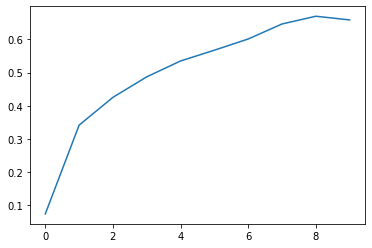

In [218]:
# look at f1 curve based on different thresholds
f1_list = []


for i in range(10):
    preds_prob_b = (preds_prob > i/10).astype(int)
    print(f"F1 Score for {i/10}: ", metrics.f1_score(y_test, preds_prob_b))
    f1_list.append(metrics.f1_score(y_test, preds_prob_b))

    
plt.plot(f1_list)

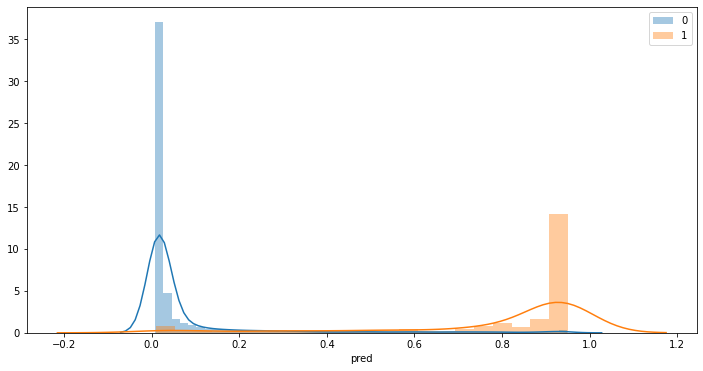

In [219]:
# look at distribution of predictions, split by actual class
hist =  pd.DataFrame(zip(y_test, preds_prob))
hist.columns = ['actual', 'pred']

plt.figure(figsize = (12,6))

for i in hist['actual'].unique():
    sns.distplot(hist['pred'][hist['actual'] == i], label=i)

    plt.legend(loc='best')

In [220]:
hist.groupby('actual').describe()

pred                                                              \
          count      mean       std       min       25%       50%       75%   
actual                                                                        
0       10765.0  0.076501  0.168492  0.008390  0.012384  0.017632  0.035219   
1         431.0  0.796608  0.252239  0.009828  0.778121  0.925245  0.941347   

                  
             max  
actual            
0       0.948368  
1       0.949723

In [221]:
# using above information, set the threshold to 0.8
preds_prob_b = (preds_prob > .8).astype(int)

Text(0.5, 257.44, 'Predicted label')

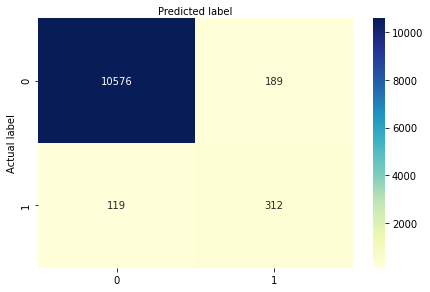

In [222]:
# show confusion matrix to understand the share of correct/incorrect predictions

confusion_matrix = metrics.confusion_matrix(y_test, preds_prob_b)

fig, ax = plt.subplots()
tick_marks = np.arange(2)
plt.xticks(tick_marks, [0,1])
plt.yticks(tick_marks, [0,1])

sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [223]:
# overall evaluation metrics for the model
print("Accuracy: ",  metrics.accuracy_score(y_test, preds_prob_b))
print("AUC: ", metrics.roc_auc_score(y_test, preds_prob))
print("F1 Score: ", metrics.f1_score(y_test, preds_prob_b))
print("Precision Score: ", metrics.precision_score(y_test, preds_prob_b))
print("Recall Score: ", metrics.recall_score(y_test, preds_prob_b))

Accuracy:  0.9724901750625223
AUC:  0.9649209057021821
F1 Score:  0.6695278969957082
Precision Score:  0.6227544910179641
Recall Score:  0.7238979118329466


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


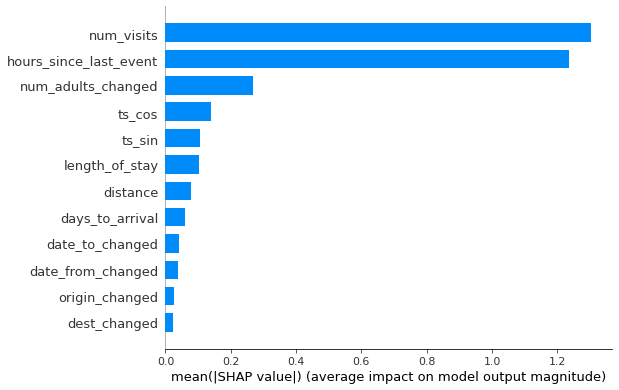

In [224]:
# look at feature importance using SHAP
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

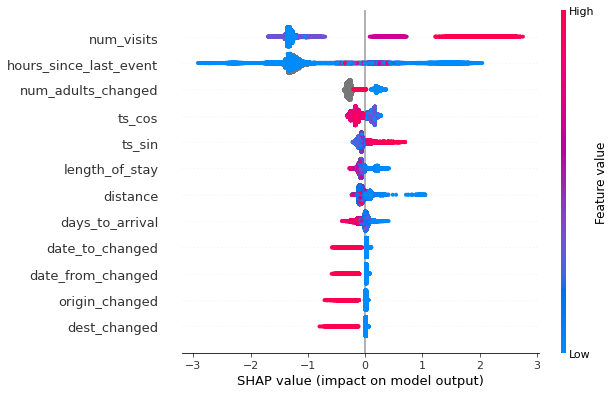

In [225]:
# look at feature impact on model
shap.summary_plot(shap_values, X_train)